Get data

In [8]:
import pandas as pd
from helpers.data_preprocessing import DataProcesser

from helpers.data_loader import DataLoader
from helpers.data_preprocessing import DataProcesser

def load_comments():
    code = DataLoader.load_csv_file("./../../data/code_data.csv", ['code'])

    def load_longer_code():
        f = open("./../../data/code_javadoc.txt", "r")
        Lines = f.readlines()
        code_long = []
        for line in Lines:
            line = line.rstrip()
            # print(line)
            code_long.append(line)
        f.close()
        return code_long

    code_long = load_longer_code()
    for index, row in code.iterrows():
        curr_code_long = code_long[index]
        if curr_code_long != '':
            row['code'] = curr_code_long
    return code
code = load_comments()
code.head()

df = pd.read_csv("./../../data/train_set_0520.csv", usecols=['comment', 'non-information'])
df['code'] = code['code']
df.head()

,comment,non-information,code
0,@implNote taken from {@link com.sun.javafx.sce...,yes,"""public static void showContextMenu(TextArea t..."
1,icon.setToolTipText(printedViewModel.getLocali...,yes,"TABLE_ICONS.put(SpecialField.PRINTED, icon);"
2,Synchronize changes of the underlying date val...,no,BindingsHelper.bindBidirectional(valueProperty...
3,Ask if the user really wants to close the give...,yes,"""private boolean confirmClose(BasePanel panel)..."
4,css: information *,no,"INTEGRITY_INFO(MaterialDesignIcon.INFORMATION),"


Preprocess comments and code
1. Separate words from camel case and snake case,
2. To lower case,
3. Remove java tags and keywords,
4. remove accented chars,
5. stem

In [10]:
df['comment'] = df['comment'].apply(str)
df['comment'] = df['comment'].apply(DataProcesser.extract_camel_case)
df['comment'] = df['comment'].apply(DataProcesser.remove_stopwords)
df['comment'] = df['comment'].apply(DataProcesser.extract_snake_case)
df['comment'] = df['comment'].apply(DataProcesser.preprocess)

df['code'] = df['code'].apply(str)
df['code'] = df['code'].apply(DataProcesser.extract_camel_case)
df['code'] = df['code'].apply(DataProcesser.extract_snake_case)
df['code'] = df['code'].apply(DataProcesser.remove_java_keywords)
df['code'] = df['code'].apply(DataProcesser.preprocess)
df['code'] = df['code'].apply(DataProcesser.remove_stopwords)

df.head()

,comment,non-information,code
0,impl note taken link com sun javafx scene cont...,yes,show context menu text area text area context ...
1,icon set tool tip text pred view model get local,yes,tabl icon put special field pred icon
2,synchron chang underli date valu tempor access...,no,bind helper bind bidirect valu properti tempor...
3,ask user realli want close given databa,yes,confirm close base panel panel filenam panel g...
4,css inmat,no,egriti info materi design icon inmat


Count common words between code and comments

In [11]:
from helpers.textual_analysis import *
from helpers.text_similarity import TextSimilarity

df['word_counts'] = df.apply(lambda row: count_common_words(row['comment'], row['code']), axis=1)
df['jaccard_score'] = df.apply(lambda row: TextSimilarity.get_similarity_score(
            s1=row['comment'],
            s2=row['code'],
            type='JACC'), axis=1)
df['cosine_score'] = df.apply(lambda row: TextSimilarity.get_similarity_score(
            s1=row['comment'],
            s2=row['code'],
            type='COSINE_TFIDF'), axis=1)
df.head()


,comment,non-information,code,word_counts,jaccard_score,cosine_score
0,impl note taken link com sun javafx scene cont...,yes,show context menu text area text area context ...,0.036697,0.018692,1.267541
1,icon set tool tip text pred view model get local,yes,tabl icon put special field pred icon,0.235294,0.133333,0.457809
2,synchron chang underli date valu tempor access...,no,bind helper bind bidirect valu properti tempor...,0.352941,0.214286,0.744121
3,ask user realli want close given databa,yes,confirm close base panel panel filenam panel g...,0.032967,0.016760,0.271290
4,css inmat,no,egriti info materi design icon inmat,0.250000,0.142857,0.225480


Average value of cosine similarity for non-information: yes

In [12]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['cosine_score'].mean()

0.1660885374591356

Average value of cosine similarity for non-information: yes, graph

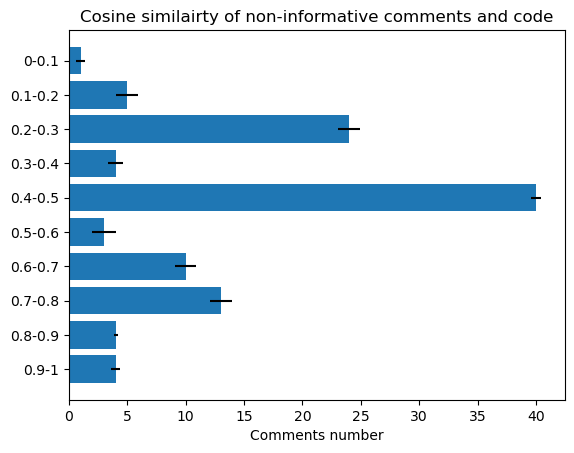

In [13]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['cosine_score'] < 0.1 * i]
    num = comments_smaller[comments_smaller['cosine_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Cosine similairty of non-informative comments and code')

plt.show()

Average value of cosine similarity for non-information: no

In [14]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['cosine_score'].mean()

0.38386380749900356

Average value of cosine similarity for non-information: no, graph

[5, 15, 85, 19, 52, 24, 39, 42, 22, 33]
[5, 15, 85, 19, 52, 24, 39, 42, 22, 33]


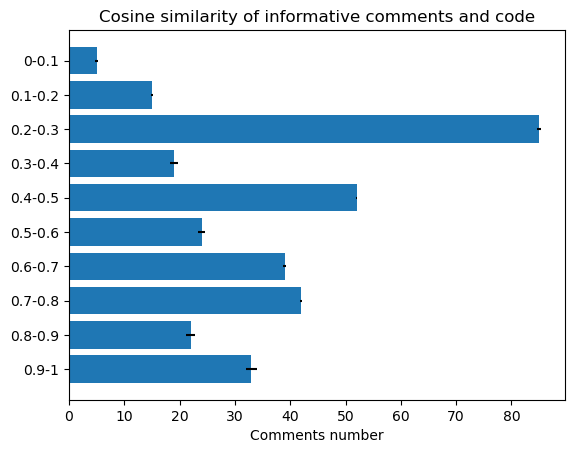

In [16]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['cosine_score'] < 0.1 * i]
    num = comments_smaller[comments_smaller['cosine_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)
print(arr)
print(arr)
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Cosine similarity of informative comments and code')

plt.show()

Median of cosine similarity non-information: yes

In [17]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['cosine_score'].median()


0.0

Average of counts of common words between code and comments for non-information: no

In [18]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['cosine_score'].median()

0.03702478013580694

Average value of jaccard index for non-information: yes

In [19]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['jaccard_score'].mean()

0.05388015279618415

Average value of jaccard index for non-information: yes, graph

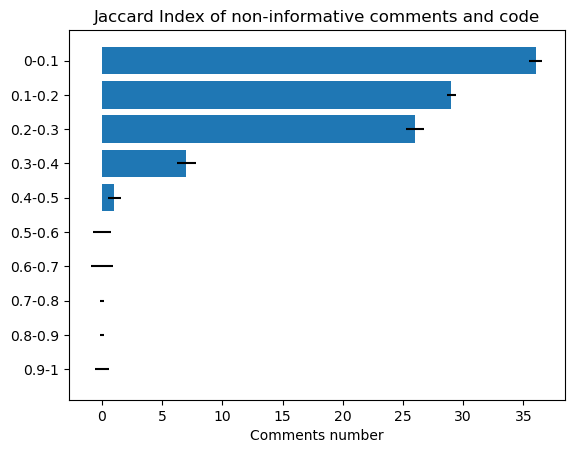

In [21]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['jaccard_score'] < 0.1 * i]
    num = comments_smaller[comments_smaller['jaccard_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Jaccard Index of non-informative comments and code')

plt.show()

Average value of Jaccard index for non-information: no

In [22]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['jaccard_score'].mean()

0.04443687686441475

Average value of jaccard index for non-information: no, graph

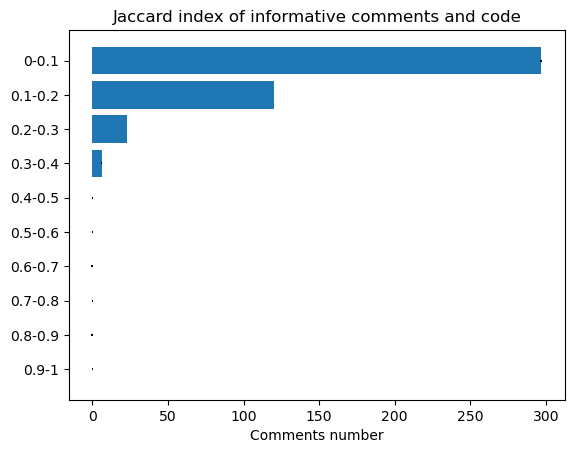

In [24]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['jaccard_score'] < 0.1 * i]
    num = comments_smaller[comments_smaller['jaccard_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Jaccard index of informative comments and code')

plt.show()

Median of jaccard index non-information: yes

In [25]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['jaccard_score'].median()


0.0

Average of jaccard index between code and comments for non-information: no

In [26]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['jaccard_score'].median()


0.001091703056768559